# Image alignment with toolbox
***
  
  
Aligning our microscope data is important when we need to make figures or when we are analising things that happen in either channel relative to one another.  The following notebook walks through some of the features of the `toolbox.alignment` and `toolbox.point_fitting` modules and sets out a pipeline to align your images. To get started, look at this cat I found in the scikit-image package files, i bet it bites.


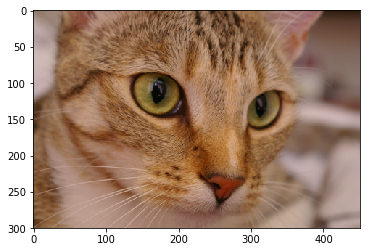

In [2]:
import toolbox.testdata as test
import toolbox.alignment as al
import toolbox.point_fitting as pt
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
plt.imshow(data.chelsea(), interpolation='nearest')

Okay then, I am going to open up one of the test images provided in the `toolbox` package. Then using `im_split` we can display each channel independently

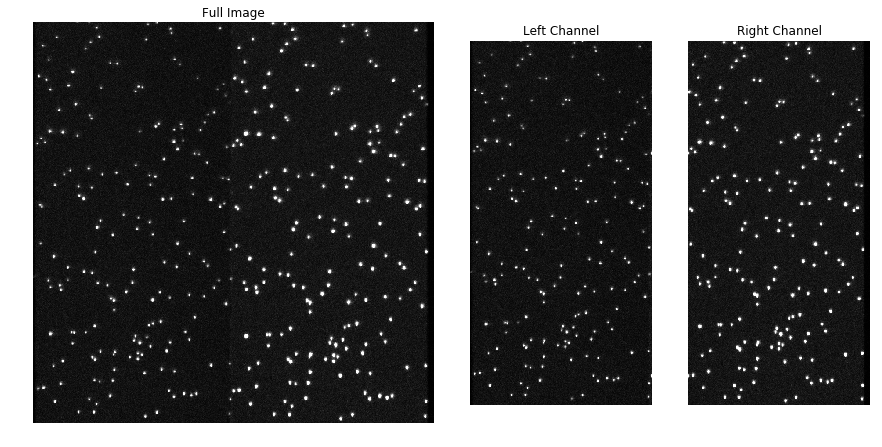

In [3]:
im = test.image_stack()[0]
ch1,ch2 = al.im_split(im)

fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=2)
ax1.axis('off')
ax1.set_title("Full Image")
ax1.imshow(im, cmap = "binary_r", vmax = im.max()/2)

ax2 = plt.subplot2grid((1, 4), (0, 2), colspan=1)
ax2.axis('off')
ax2.set_title("Left Channel")
ax2.imshow(ch1, cmap = "binary_r", vmax = im.max()/2)
ax3 = plt.subplot2grid((1, 4), (0, 3), colspan=1)
ax3.axis('off')
ax3.set_title("Right Channel")
ax3.imshow(ch2, cmap = "binary_r", vmax = im.max()/2)

Before we can align the two channels, we first need to determine how out of register the two channels are. To do this the package follows the following steps

1. split the channels 
* locate all of the maxima in both channels
* assign maxima in each channel to each other.
* calculate the absolute distance between corresponding maxima
* then average over several measurements to get a global offset value in x and y

Im going to make explicit some of these steps which are hidden in the package for the most part. We did step 1. above, next lets locate the maxima using the `find_maxima` function for which there is an entire notebook on: https://github.com/ReddingLab/Learning/blob/master/image-analysis-basics/finding-local-maxima.ipynb

(-0.5, 255.5, 511.5, -0.5)

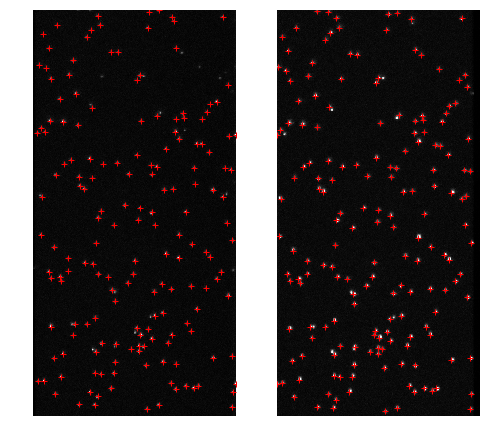

In [4]:
im = test.image_stack()[0]
ch1,ch2 = al.im_split(im)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(121)
ax1.imshow(ch1,cmap=plt.cm.gray)
ax1.plot(*zip(*pt.find_maxima(ch1,10)), 'r+')
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(ch2,cmap=plt.cm.gray)
ax2.plot(*zip(*pt.find_maxima(ch2,10)), 'r+')
ax2.axis('off')

Now lets assign each of these maxima to each other. This step uses `scipy.spatial.cKDTree` to find nearest neighbors in the two maxima lists. This is a bit messy, but the data are cleaned up a little after by checking if any maxima is assigned to more than one corresponding maxima in the other channel, if so, we look to which ever maxima pair are at the smallest distance from one another, we keep that as a maxima pair, and remove the other pairs. 

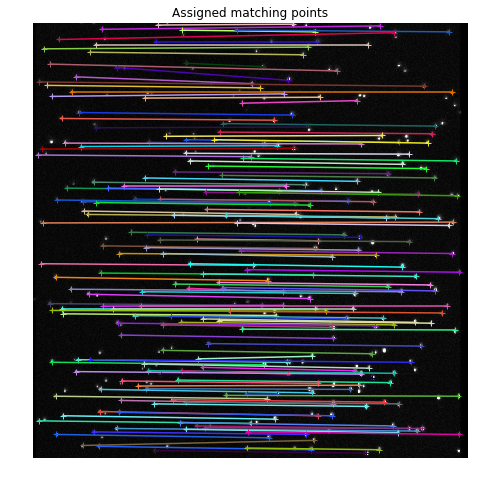

In [5]:
im = test.image_stack()[0]
al.plot_assigned_maxima(im)

It's clear there are some significant mistakes, but by and large, the assignment works. Lets look at this another way though: as a histogram of distances. Note, the distance I mean here is the how far two assigned maxima would be from one another if we overlayed the two channels directly. Additionally, I'm going to use the `get_offset_distribution` function from `toolbox.alignment`, which will also fit each maximum with a 2D Gaussian before calculating offset distance.

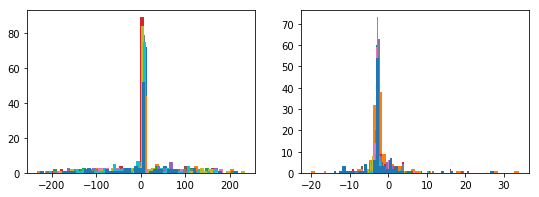

In [6]:
mean_x, mean_y = [],[]
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(121)  
ax2 = fig.add_subplot(122)  
for im in test.image_stack():
    xdist,ydist = al.get_offset_distribution(im)
    mean_x.append(np.mean(xdist))
    mean_y.append(np.mean(ydist))
    ax1.hist(xdist,50)
    ax2.hist(ydist,50)


There is a fair amount of noise in the distributions, but the signal is obvious. In a previous effort, I spent a fair amount of effort trying to filter the background noise out before fitting. I have since changed how the fit is performed and now the fit is considerably less sensitive to the noise and we do the fit without filtering at all. So now the next step is to fit these distributions and determine the mean offset values.

This step is the likely starting place for aligning images in practice. As we go from here I am going to outline what I think is a practical alignment workflow.


#### Step 1: use the defaults.

To begin, call the `inspect_global_fit` function and just let it run as default.

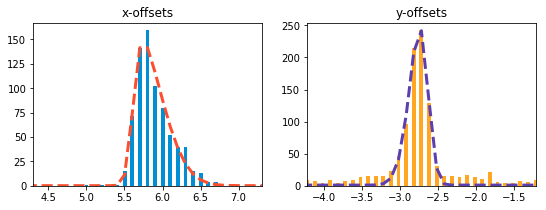

In [7]:
plt.rcParams["figure.figsize"] = 9,3
dx, dy, params = al.inspect_global_fit(test.image_stack())

In [8]:
import pandas as pd

var_x,var_y = [],[]

for i in range(len(params[0])):
    var_x.append(np.sqrt(params[1][i][i]))
    var_y.append(np.sqrt(params[3][i][i]))


xfit = ['{:.2f}'.format(i) for i in params[0]]
xerr = ['{:.3f}'.format(i) for i in var_x]
yfit = ['{:.2f}'.format(i) for i in params[2]]
yerr = ['{:.3f}'.format(i) for i in var_y]

result_table = pd.DataFrame([xfit,xerr,yfit,yerr],
                  index=['x-offset','x errors','y-offset','y errors'],
                  columns=('loc', 'scale', 'shape',
                           'amplitude', 'baseline'))
print(result_table)

            loc  scale  shape amplitude baseline
x-offset   5.61   0.34   4.58     71.44     0.14
x errors  0.001  0.001  0.076     0.199    0.009
y-offset  -2.65   0.18  -1.78     77.00     1.09
y errors  0.004  0.004  0.132     0.743    0.122


First of all, the distributions and fits look relatively good, but notice that we have picked up a skew (the shape parameter) in the x-dimension and maybe in y also. Before we discuss the skew in the data, let me make a point about what this distribution means: **That if one were to do an experiment, first aligning the data with an equivalent data set to the one used here, the limit of our ability to say two points are in the same place in separate channels is ~0.2 pixels, or ~50nm**. Thats actually pretty good, but we can do better, which will be the subject of a later document. If this is how your data look after this step, then skip to Step 3: alignment.

#### Step 2: tune your fit.
However if your fit does not look good, or doesn't exist, there are some tools to help diagnose the problem. These tools are based around what I think are the key parameters that determine the effectiveness of our algorithm: `bbox`, `fsize`, and `binwidth`. The first two are passed to the `find_maxima` routine, if they are suboptimal, the number and quality of discovered maxima can be problematic. If there are concerning numbers of individual offset measurments, it should be obvious from the histograms produced by `inspect_global_fit` provided `showplot` is set to `True`. However, you can also run the code in the notebook above showing the overlay of maxima locations to the orignal image, or `plot_assigned_maxima`. For more information check out the finding maxima notebook.

There are two ways to affect how well `scipy.optimize.curve_fit` performs when fitting the data. Either by providing custom initial conditions or through the parameter `binwidth`. To the former, a `p0` list can be passed directly to `inspect_global_fit`. For the latter, the binwidth is the resolution to which the data are binned before fitting, there is no "right" answer for the proper binwidth to use, but becuase I think its a good number, the default is 0.1 pixels. Certainly, overbinning and underbinning can both make the fitting difficult. Have a look at some of the behavior of the fitting as a function of binwidth below. 

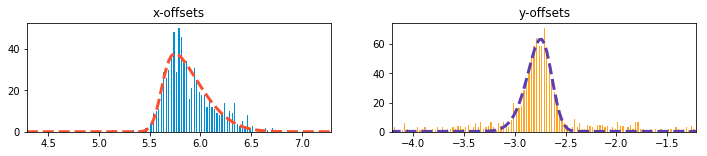

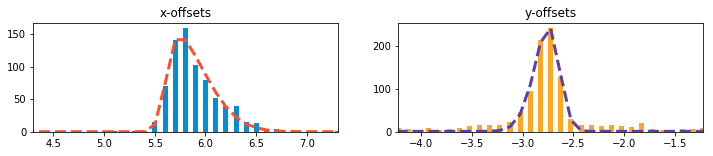

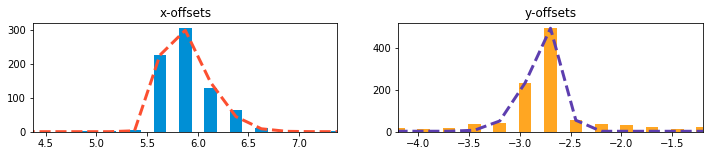

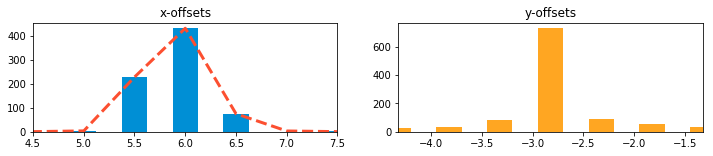

In [9]:
plt.rcParams["figure.figsize"] = 12,2
for i in [.025,.1,.25,.5]:
    data = al.inspect_global_fit(test.image_stack(), binwidth=i)

A final thing to consider is a problematic image. It happens regularly enough that for whatever reason a particular image perfectly breaks the analysis and the results poison the whole. In order to check if this is happening, we can plot the distributions from each image that goes into the global average.

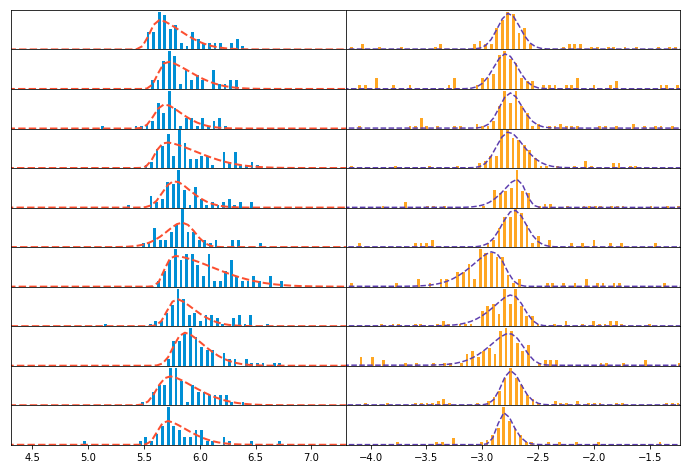

In [10]:
plt.rcParams["figure.figsize"] = 12,8
params = al.inspect_individual_fits(test.image_stack(),binwidth=.05)

Looking at this, you might make a case that the sixth image is a bit extra, and that you should remove it from the analysis. I wouldn't agree with you, but for demonstration purposes, here's how you would.

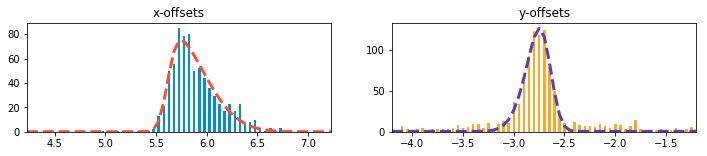

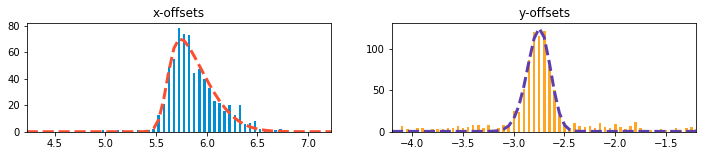

In [17]:
plt.rcParams["figure.figsize"] = 12,2
data = al.inspect_global_fit(test.image_stack(),binwidth=0.05)
new_stack = test.image_stack()
del new_stack[6]
newdata = al.inspect_global_fit(new_stack,binwidth=0.05)

In [18]:
print("x-offset change:  " + "%.2f" % (266*(data[0]-newdata[0])) + "nm")
print("y-offset change:  " + "%.2f" % (266*(data[1]-newdata[1])) + "nm")

x-offset change:  1.28nm
y-offset change:  4.84nm


Now I want to return to the skew. At this time, I do not now the origin of where it is coming from. It could be a specific issue with the test data used to build the `toolbox` functions, it could be inherent in the functions themselves, it could be optical on the microscope, or a real product of the data manipulations we are doing. To check on the idea that it has to do with the microscope, I'm going to plot the measured offset relative to it's position in the image.   

In the plot below, 
* lighter colors are larger offsets, darker colors are smaller
* x-offsets are plotted on the left, y-offsets on the right.

We are looking for spatial organization of shades of colors, for example, are all of the light colors (high values) clustered together in a corner.

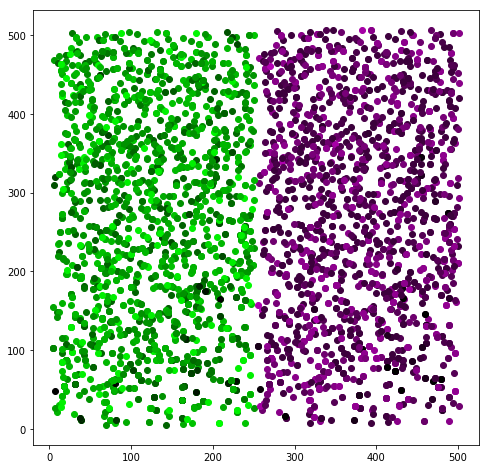

In [15]:
from scipy.spatial import cKDTree

def offset_and_position(Image):
    ch1,ch2 = al.im_split(Image)
    ch1_maxima = pt.find_maxima(ch1,10)
    ch2_maxima = pt.find_maxima(ch2,10)
    x_data,y_data = [],[]
    mytree = cKDTree(ch1_maxima)
    dist, indexes = mytree.query(ch2_maxima)
    for i in range(len(ch2_maxima)):
        x1, y1 = ch1_maxima[indexes[i]]
        x2, y2 = ch2_maxima[i]
        fit_ch1 = pt.fit_routine(ch1, x1, y1, 9)
        fit_ch2 = pt.fit_routine(ch2, x2, y2, 9)
        try:
            x_data.append((x1,y1,fit_ch1[1]-fit_ch2[1]))
            y_data.append((x1,y1,fit_ch1[2]-fit_ch2[2]))
        except TypeError:
            pass
    return x_data,y_data
     
data = al.inspect_global_fit(test.image_stack(),showplot = False)
global_dx = data[0]
global_dy = data[1]

fig = plt.figure(figsize=(8,8))
for im in test.image_stack():
    x_data,y_data = offset_and_position(im)
    xoff = [offset for x,y,offset in x_data]
    yoff = [offset for x,y,offset in y_data]

    for x,y,offset in x_data:     
        scaled_x_offset = (offset-min(xoff))/(max(xoff)-min(xoff))
        plt.plot(x,y,color = (0.,scaled_x_offset, 0.), marker = 'o')

    for x,y,offset in y_data:  
        x=x+256-global_dx
        y=y-global_dy
        scaled_y_offset = (offset-min(yoff))/(max(yoff)-min(yoff))
        plt.plot(x,y,color = (scaled_y_offset, 0.,scaled_y_offset), marker = 'o')
    

It doesn't seem obvious that there is a bias, but we can plot this data another way to check. Plotted as scatters where we plot offsets against their (x,y) positions.

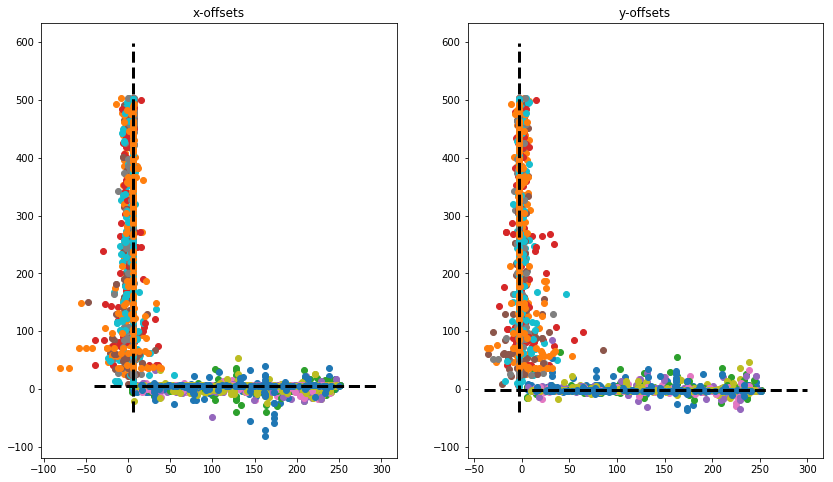

In [19]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)  
ax2 = fig.add_subplot(122,sharey=ax1)

for im in test.image_stack():
    x_data,y_data = offset_and_position(im)
    xx,xy,xoff = zip(*x_data)
    yx,yy,yoff = zip(*y_data)
    ax1.scatter(xx,xoff)
    ax1.scatter(xoff,xy)
    ax2.scatter(yx,yoff)
    ax2.scatter(yoff,yy)

    
X = [i for i in np.arange(-40,300,1)]
Y = [i for i in np.arange(-40,600,1)]
data = al.inspect_global_fit(test.image_stack(),showplot = False)
global_dx = data[0]
global_dy = data[1]
ax1.set_title("x-offsets")
ax1.plot(X,[global_dx for i in X],"k--",linewidth = 3)
ax1.plot([global_dx for i in Y],Y,"k--",linewidth = 3)
ax2.set_title("y-offsets")
ax2.plot(X,[global_dy for i in X],"k--",linewidth = 3)
ax2.plot([global_dy for i in Y],Y,"k--",linewidth = 3)

Again, not super obvious that there is bias, although you could make a claim that both the x- and y-offsets near the origin in the y-dimension are noisier, and that might merit looking into.

#### Step 3: alignment.

Okay once we have offset values for the x- aand y-dimensions, we are ready to adjust the original image. We do so with `align_by_offset` which returns a new image where the two channels are now aligned but are still side-by-side channels in a single image. Any aligned images can be saved as TIFF and opened in ImageJ to be merged into color images or to do anyother processing or analysis. However, there is also a built in tool, `overlay`, if you would like to convert your two channel image into a merged 8-bit RGB image. 

5.612082237088681 -2.651765063702885


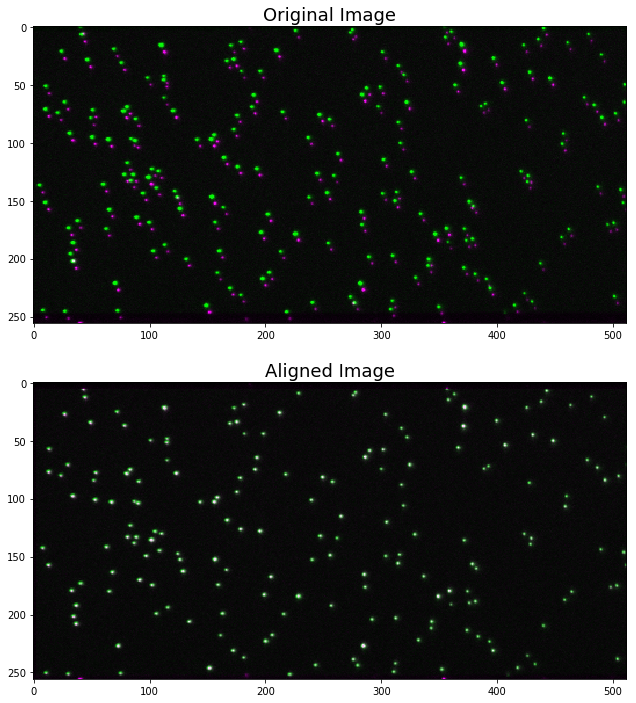

In [25]:
im = test.image_stack()[0]
im_old = al.overlay(im)
print(dx,dy)
igf_adj_image = al.align_by_offset(im,dx,dy)
im_igf = al.overlay(igf_adj_image)
    
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)  
ax2 = fig.add_subplot(212,sharex=ax1)
ax1.set_title('Original Image', fontsize = "18")
ax2.set_title('Aligned Image', fontsize = "18")
ax1.imshow(im_old)
ax2.imshow(im_igf)
plt.show() 


And thats really it. In practice, the whole shebang ought to just come down to running a couple lines of code.

```
>>> import skimage.external.tifffile as skim
>>> import toolbox.alignment as al
>>> alignment_image = skim.imread(path_to_file)
>>> dx, dy, params = al.inspect_global_fit([alignment_image])
>>> to_be_aligned_image = skim.imread(path_to_file)
>>> adj_image = al.align_by_offset(to_be_aligned_image,dx,dy)
```

In [6]:
import os

imlist = []
for i in os.listdir():
    if i.endswith("ipynb"):
        imlist.append(imread(i))

finding-local-maxima.ipynb
viewing-stacks.ipynb
fitting-gaussians.ipynb
Image-alignment-with-toolbox.ipynb
